### Introduction
Real-world data rarely comes clean. Using Python and its libraries, we can gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it. This is called data wrangling. I will document my wrangling efforts in a Jupyter Notebook, plus showcase them through analyses and visualizations using Python (and its libraries).
The dataset that I will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

Goal: wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for worthy analyses and visualizations.

#### The Data

1- Twitter archive file: download this file manually by clicking the following link: twitter_archive_enhanced.csv

2- The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

3- Twitter API & JSON: Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count.

In [51]:
# Load requored packages:
import pandas as pd
import numpy as np
import requests
import tweepy
import os
import json
import time
import re
import matplotlib.pyplot as plt
import warnings

### Gathering data

#### I.Twitter Archive File

In [52]:
# Read ".csv" file
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [53]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

#### II. Image Predictions File

In [54]:
# Download ".tsv" file using requests package
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open('./image_predictions.tsv', 'wb') as file:
    file.write(response.content)
    
# Read ".tsv" file
image_predictions = pd.read_csv('./image_predictions.tsv', sep='\t')

In [55]:
image_predictions.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


#### III. Twitter API and JSON

In [56]:
consumer_key = 'RlgSDyOO2s1tz4DKlqHy6ZkZw'
consumer_secret = 'MYWSo5Jom9BcsnfBz74Bzr29gQt9FqgPpVWQLaEcgKVnRsFG6s' 
access_token = '1041190163680878592-c88PWhPZAfw1ekLrZeWsdJK8p121GN'
access_token_secret = 'VSTAkP9oKE8OrePvUWWAd48Q8ZZClwA7zApl1iE8SH8Li'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Construct the API instance
api = tweepy.API(auth, 
                 parser = tweepy.parsers.JSONParser(), # Parse the result to Json Object
                 wait_on_rate_limit = True, # Automatically wait for rate limits to replenish
                 wait_on_rate_limit_notify = True) # Print a notification when Tweepy is waiting for rate limits to replenish

In [57]:
# Liste where we will store the dictionaries of our result
df_list = []
# Liste frame where we will store the tweet_id of the errors
error_list = []

# Calculate the time of excution
start = time.time()

# Get the tweet object for all the teweets in archive dataframe 
for tweet_id in twitter_archive['tweet_id']:
    try:
        page = api.get_status(tweet_id, tweet_mode = 'extended')
        # Print one page to look at the structure of the returned file
        # and the names of attributes
        # print(json.dumps(page, indent = 4))
        #break
        
        favorites = page['favorite_count'] # How many favorites the tweet had
        retweets = page['retweet_count'] # Count of the retweet
        user_followers = page['user']['followers_count'] # How many followers the user had
        user_favourites = page['user']['favourites_count'] # How many favorites the user had
        date_time = page['created_at'] # The date and time of the creation
        
        df_list.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'retweets': int(retweets),
                        'user_followers': int(user_followers),
                        'user_favourites': int(user_favourites),
                        'date_time': pd.to_datetime(date_time)})
    
    # Catch the exceptions of the TweepError
    except Exception as e:
        print(str(tweet_id)+ " _ " + str(e))
        error_list.append(tweet_id)

# Calculate the time of excution
end = time.time()
print(end - start)

888202515573088257 _ [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 _ [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937 _ [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 _ [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 _ [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 _ [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 _ [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648 _ [{'code': 144, 'message': 'No status found with that ID.'}]
837012587749474308 _ [{'code': 144, 'message': 'No status found with that ID.'}]
827228250799742977 _ [{'code': 144, 'message': 'No status found with that ID.'}]
802247111496568832 _ [{'code': 144, 'message': 'No status found with that ID.'}]
775096608509886464 _ [{'code': 144, 'message': 'No status found with that ID.'}]
770743923962707968 _ [{'code

Rate limit reached. Sleeping for: 738


754011816964026368 _ [{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 736


1905.037590265274


In [58]:
# lengh of the result
print("The lengh of the result", len(df_list))
# The tweet_id of the errors
print("The lengh of the errors", len(error_list))

The lengh of the result 2342
The lengh of the errors 14


In [59]:
# Create DataFrames from list of dictionaries
json_tweets = pd.DataFrame(df_list, columns = ['tweet_id', 'favorites', 'retweets',
                                               'user_followers', 'user_favourites', 'date_time'])
# Save the dataFrame in file
json_tweets.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [60]:

# Read the saved tweet_json.txt file into a dataframe
tweet_json = pd.read_csv('tweet_json.txt', encoding = 'utf-8')
tweet_json.head()

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
0,892420643555336193,38186,8364,7461669,140024,2017-08-01 16:23:56
1,892177421306343426,32755,6176,7461669,140024,2017-08-01 00:17:27
2,891815181378084864,24660,4088,7461669,140024,2017-07-31 00:18:03
3,891689557279858688,41517,8495,7461669,140024,2017-07-30 15:58:51
4,891327558926688256,39708,9201,7461669,140024,2017-07-29 16:00:24


### Assessment

In [61]:
#### I. Twitter Archive Dataset

In [62]:
# Visual assessment through some samples of the dataset
twitter_archive.sample(50)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
794,773336787167145985,NaN,NaN,2016-09-07 01:47:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Fizz. She thinks love is a...,7.713808e+17,4.196984e+09,2016-09-01 16:14:48 +0000,https://twitter.com/dog_rates/status/771380798...,11,10,Fizz,None,None,None,None
2020,672095186491711488,NaN,NaN,2015-12-02 16:49:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tuco. That's the toast that killed his...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672095186...,9,10,Tuco,None,None,None,None
2306,666835007768551424,NaN,NaN,2015-11-18 04:27:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",These are Peruvian Feldspars. Their names are ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666835007...,10,10,None,None,None,None,None
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
788,774314403806253056,NaN,NaN,2016-09-09 18:31:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I WAS SENT THE ACTUAL DOG IN THE PROFILE PIC B...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/774314403...,14,10,None,None,None,None,None
1612,685321586178670592,NaN,NaN,2016-01-08 04:46:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Rocky. He sleeps like a psychopath. 10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/685321586...,10,10,Rocky,None,None,None,None
1985,672898206762672129,NaN,NaN,2015-12-04 22:00:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cheryl AKA Queen Pupper of the Skies. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672898206...,11,10,Cheryl,None,None,pupper,None
1871,675147105808306176,NaN,NaN,2015-12-11 02:56:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're presenting a group project and the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675147105...,10,10,None,None,None,None,None
2262,667546741521195010,NaN,NaN,2015-11-20 03:35:20 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Here is George. George took a selfie of his ne...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667546741...,9,10,George,None,None,None,None
2334,666293911632134144,NaN,NaN,2015-11-16 16:37:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a funny dog. Weird toes. Won't come do...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666293911...,3,10,a,None,None,None,None


In [63]:
# Programmatical Assessment of the dataset
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [64]:
# Descriptive statistics
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [65]:
#### II. Image Predictions Dataset

In [66]:
# Visual assessment through some samples of the dataset
image_predictions.sample(50)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
486,675497103322386432,https://pbs.twimg.com/media/CV_ZAhcUkAUeKtZ.jpg,1,vizsla,0.519589,True,miniature_pinscher,0.064771,True,Rhodesian_ridgeback,0.061491,True
738,687124485711986689,https://pbs.twimg.com/media/CYkoE10WEAAWqxm.jpg,1,car_mirror,0.997121,False,seat_belt,0.000375,False,beagle,0.000216,True
1929,858471635011153920,https://pbs.twimg.com/media/C-nnZBdXkAAB-wg.jpg,1,Pembroke,0.987407,True,Cardigan,0.008723,True,basenji,0.003424,True
1513,786595970293370880,https://pbs.twimg.com/media/CuqM0fVWAAAboKR.jpg,1,Pembroke,0.709512,True,Cardigan,0.287178,True,chow,0.000570,True
253,670727704916926465,https://pbs.twimg.com/media/CU7nSZEW4AA6r5u.jpg,1,wood_rabbit,0.368562,False,tabby,0.309675,False,Egyptian_cat,0.154914,False
438,674422304705744896,https://pbs.twimg.com/media/CVwHgblWcAACWOD.jpg,1,golden_retriever,0.964497,True,Labrador_retriever,0.009006,True,tennis_ball,0.007139,False
1781,828708714936930305,https://pbs.twimg.com/media/C4AqLSgVYAEg8nt.jpg,1,hippopotamus,0.942911,False,Mexican_hairless,0.008388,True,ice_lolly,0.006206,False
197,669603084620980224,https://pbs.twimg.com/media/CUroc7QW4AATIff.jpg,1,Maltese_dog,0.659619,True,Tibetan_terrier,0.193539,True,Shih-Tzu,0.039327,True
145,668625577880875008,https://pbs.twimg.com/media/CUdvambWoAA007z.jpg,1,ox,0.071536,False,groenendael,0.054455,True,Angora,0.045028,False
123,668226093875376128,https://pbs.twimg.com/media/CUYEFlQXAAUkPGm.jpg,1,trombone,0.390339,False,cornet,0.314149,False,French_horn,0.255182,False


In [67]:
# Programmatical Assessment of the dataset
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [68]:
# Descriptive statistics
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [69]:
#### III. Tweet_json Dataset

In [70]:
# Visual assessment through some samples of the dataset
tweet_json.sample(50)

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
2289,666996132027977728,247,95,7461714,140024,2015-11-18 15:07:24
1306,706346369204748288,3622,987,7461699,140024,2016-03-06 05:11:12
1066,738891149612572673,113,6,7461699,140024,2016-06-04 00:32:32
1151,722974582966214656,4308,1675,7461699,140024,2016-04-21 02:25:47
1065,739238157791694849,121843,62258,7461699,140024,2016-06-04 23:31:25
1308,706291001778950144,1788,499,7461699,140024,2016-03-06 01:31:11
346,830956169170665475,8440,1620,7461672,140024,2017-02-13 01:46:03
856,761745352076779520,4527,936,7461673,140024,2016-08-06 02:06:59
1064,739485634323156992,7571,3157,7461699,140024,2016-06-05 15:54:48
1845,675497103322386432,3248,1364,7461714,140024,2015-12-12 02:07:14


In [71]:
# Programmatical Assessment of the dataset
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 6 columns):
tweet_id           2342 non-null int64
favorites          2342 non-null int64
retweets           2342 non-null int64
user_followers     2342 non-null int64
user_favourites    2342 non-null int64
date_time          2342 non-null object
dtypes: int64(5), object(1)
memory usage: 109.9+ KB


In [72]:
# Descriptive statistics
tweet_json.describe()

,tweet_id,favorites,retweets,user_followers,user_favourites
count,2.342000e+03,2342.000000,2342.000000,2.342000e+03,2342.000000
mean,7.422212e+17,7995.327071,2948.147737,7.461686e+06,140023.969257
std,6.832408e+16,12374.846512,4958.301032,6.289966e+01,0.302197
min,6.660209e+17,0.000000,0.000000,7.461068e+06,140021.000000
25%,6.783509e+17,1382.250000,591.750000,7.461673e+06,140024.000000
50%,7.186224e+17,3480.000000,1376.500000,7.461699e+06,140024.000000
75%,7.986971e+17,9798.750000,3440.000000,7.461702e+06,140024.000000
max,8.924206e+17,164826.000000,84023.000000,7.461714e+06,140024.000000


### Quality issues (Content issues)

#### Twitter_archive Dataset

- Convert each column to its appropriate type
- Remove all columns and rows that we do not need for our intended analysis
- Remove column "date_time" of API dataset, and separate timestamp into day-month-year
- Invalid values were spotted in numerator and denominator columns
- Invalid column names
- retweets should be removed
- column type should be changed to sting in the followings: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id and tweet_id

#### Image Predictions Dataset

- Handling missing values
- Repeated jpg_url

#### Tweet_json Dataset

- Duplicated tweet_id

### Tidiness issues (Structural issues)

- Various stages of dogs in columns instead of rows
- We may want to add a gender column from the text columns in archives dataset
- All tables should be part of one dataset

In [73]:
### Cleaning Process

In [74]:
# Make a copy each dataset
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
tweet_json_clean = tweet_json.copy()

In [75]:
# Combine all datasets in one master dataset 
df = pd.merge(twitter_archive_clean, image_predictions_clean, how = 'left', on = ['tweet_id'] )
df = pd.merge(df, tweet_json_clean, how = 'left', on = ['tweet_id'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 33 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
jpg_url                       20

###### Define:
-Remove Retweets
-Remove columns associated with Retweets:retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp
-Remove duplicated values
-Keep original tweets with images

###### Code:

In [76]:
# Delete retweets
df = df[df.retweeted_status_user_id.isnull()]
df = df[df.in_reply_to_user_id.isnull()]

# Delete duplicated tweet_id
df = df.drop_duplicates()

# Delete tweets with no pictures
df = df.dropna(subset = ['jpg_url'])

# Delete columns associated with retweet
df.drop(['in_reply_to_user_id', 'in_reply_to_status_id', 
    'retweeted_status_id', 'retweeted_status_user_id',
    'retweeted_status_timestamp'], inplace = True, axis = 1) 

###### Test:

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 28 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null object
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
doggo                 1971 non-null object
floofer               1971 non-null object
pupper                1971 non-null object
puppo                 1971 non-null object
jpg_url               1971 non-null object
img_num               1971 non-null float64
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null object
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                1971 non-null object
p3                    1971 non-nu

###### Define:
-Combine dog stages into one column
-Some dogs have more than one stage. we will take the first listed stage.

###### Code:

In [78]:
Stages = ['doggo', 'floofer', 'pupper', 'puppo']
def dogstage(Stages):
    for stage in Stages:
        if stage in Stages:
            return stage
        else:
            pass
    return stage

df['Stages'] = df[['doggo', 'floofer', 
    'pupper', 'puppo']].apply(dogstage, axis = 1)
df.drop(['doggo', 'floofer', 'pupper', 'puppo'], 
    inplace = True, axis = 1)
df.Stages = df.Stages.astype('category')

###### Test:

In [79]:
print(df.Stages.value_counts())

None       1668
pupper      201
doggo        73
puppo        22
floofer       7
Name: Stages, dtype: int64


###### Define:
Remove column "date_time" of API dataset, and separate timestamp into day-month-year

###### Code:

In [80]:
df.timestamp = pd.to_datetime(df.timestamp, infer_datetime_format=True)

###### Test:

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 25 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null datetime64[ns]
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
jpg_url               1971 non-null object
img_num               1971 non-null float64
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null object
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                1971 non-null object
p3                    1971 non-null object
p3_conf               1971 non-null float64
p3_dog                1971 non-null object
favorites             1970 non-null float64
retweets              1

###### Define:
Combine dog breed predictions

###### Code:

In [82]:
# Store algorithm with its confidence level
breed = []
conf= []

# Define relative function 
def breed_conf(row):
    if row['p1_dog']:
        breed.append(row['p1'])
        conf.append(row['p1_conf'])
    elif row['p2_dog']:
        breed.append(row['p2'])
        conf.append(row['p2_conf'])
    elif row['p3_dog']:
        breed.append(row['p3'])
        conf.append(row['p3_conf'])
    else:
        breed.append('Unidentifiable')
        conf.append(0)

df.apply(breed_conf, axis = 1)

df['breed'] = breed
df['confidence'] = conf

# Remove the columns of image prediction info
df.drop(['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis=1, inplace=True)


###### Test:

In [83]:
df.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,favorites,retweets,user_followers,user_favourites,date_time,Stages,breed,confidence
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,38186.0,8364.0,7461669.0,140024.0,2017-08-01 16:23:56,None,Unidentifiable,0.000000
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,32755.0,6176.0,7461669.0,140024.0,2017-08-01 00:17:27,None,Chihuahua,0.323581


###### Define:
Correct rating numerator and denominators

###### Code:

In [84]:
# All test need to be corrected
ratings = df[df.text.str.contains( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")].text

for entry in ratings:
    m = df.text == entry
    col1 = 'rating_numerator'
    col2 = 'rating_denominator'
    df.loc[m, col1] = re.findall(r"\d+\.?\d*\/\d+\.?\d*\D+(\d+\.?\d*)\/\d+\.?\d*", entry)
    df.loc[m, col2] = 10
    
# Define correct numerators
df.loc[(df['tweet_id'] == 883482846933004288) & (df['rating_numerator'] == 5), ['rating_numerator']] = 13.5
df.loc[(df['tweet_id'] == 786709082849828864) & (df['rating_numerator'] == 75), ['rating_numerator']] = 9.75
df.loc[(df['tweet_id'] == 778027034220126208) & (df['rating_numerator'] == 27), ['rating_numerator']] = 11.27
df.loc[(df['tweet_id'] == 680494726643068929) & (df['rating_numerator'] == 26), ['rating_numerator']] = 11.26

C:\Users\Mah Di\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


###### Test:

In [85]:
df[df.text.str.contains(r"(\d+\.\d*\/\d+)")]

C:\Users\Mah Di\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,favorites,retweets,user_followers,user_favourites,date_time,Stages,breed,confidence
45,883482846933004288,2017-07-08 00:28:19,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,13.5,10,Bella,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,1.0,45261.0,9794.0,7461669.0,140024.0,2017-07-08 00:28:19,None,golden_retriever,0.943082
695,786709082849828864,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,9.75,10,Logan,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,1.0,19532.0,6705.0,7461674.0,140024.0,2016-10-13 23:23:56,None,Pomeranian,0.467321
763,778027034220126208,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,11.27,10,Sophie,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1.0,7015.0,1777.0,7461674.0,140024.0,2016-09-20 00:24:34,pupper,clumber,0.946718
1712,680494726643068929,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,11.26,10,None,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,1.0,1800.0,518.0,7461701.0,140024.0,2015-12-25 21:06:00,None,kuvasz,0.438627


###### Define:
Convert each column to its appropriate type

###### Code:

In [86]:
df['tweet_id'] = df['tweet_id'].astype(object)
df['source'] = df['source'].astype('category')
df['rating_numerator'] = df['rating_numerator'].astype(float)
df['rating_denominator'] = df['rating_denominator'].astype(float)

###### Test:

In [87]:
df.dtypes

tweet_id                      object
timestamp             datetime64[ns]
source                      category
text                          object
expanded_urls                 object
rating_numerator             float64
rating_denominator           float64
name                          object
jpg_url                       object
img_num                      float64
favorites                    float64
retweets                     float64
user_followers               float64
user_favourites              float64
date_time                     object
Stages                      category
breed                         object
confidence                   float64
dtype: object

###### Define:
Correct numerator and denominator types

###### Code:

In [88]:

df[['rating_numerator', 'rating_denominator']] = df[['rating_numerator','rating_denominator']].astype(float)


# Update numerators

df.loc[(df.tweet_id == 883482846933004288), 'rating_numerator'] = 13.5
df.loc[(df.tweet_id == 786709082849828864), 'rating_numerator'] = 9.75
df.loc[(df.tweet_id == 778027034220126208), 'rating_numerator'] = 11.27
df.loc[(df.tweet_id == 681340665377193984), 'rating_numerator'] = 9.5
df.loc[(df.tweet_id == 680494726643068929), 'rating_numerator'] = 11.26

###### Test:

In [89]:
with pd.option_context('max_colwidth', 200):
    display(df[df['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

C:\Users\Mah Di\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.50,10.0
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75,10.0
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27,10.0
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26,10.0


###### Define:
Remove duplicated jpg_url

###### Code:

In [90]:
df = df.drop_duplicates(subset=['jpg_url'], keep='last')

###### Test:

In [91]:
sum(df['jpg_url'].duplicated())

0

### Store cleaned data

In [92]:
# Store the dataset
df.to_csv('twitter_archive_master.csv', index=False, encoding = 'utf-8')
df = pd.read_csv('twitter_archive_master.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 18 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null object
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null float64
rating_denominator    1971 non-null float64
name                  1971 non-null object
jpg_url               1971 non-null object
img_num               1971 non-null float64
favorites             1970 non-null float64
retweets              1970 non-null float64
user_followers        1970 non-null float64
user_favourites       1970 non-null float64
date_time             1970 non-null object
Stages                1971 non-null object
breed                 1971 non-null object
confidence            1971 non-null float64
dtypes: float64(8), int64(1), object(9)
memory usage: 277.2+ KB


### Analysis and visualization

#### Correlation matrix

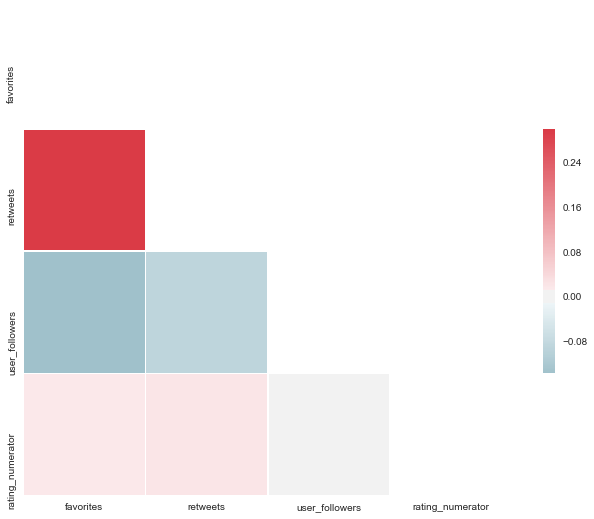

In [93]:
import seaborn as sns
import datetime as dt

sns.set(style="white")
corr = df[['source', 'favorites','retweets',
                'user_followers','rating_numerator']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

##### Summary
- A strong correlation can be seen between favorites and retweet, indicating the more favorites, the more retweets.
- User followers and retweet showes a weak correlation.

Text(0.5,1,'Retweets vs favorites')

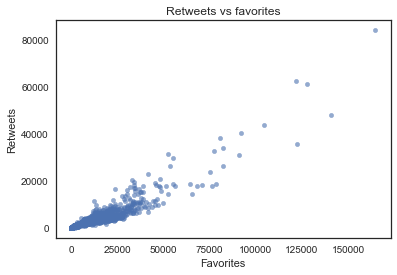

In [94]:
# Retweets Vs favorites relationship
df.plot(kind='scatter',x='favorites',y='retweets', alpha = 0.6)
plt.xlabel('Favorites')
plt.ylabel('Retweets')
plt.title('Retweets vs favorites')

##### Summary 
As illustrated in the correlation matrix, retweet and favorites are highly correlated.

#### The most favorite dog breed

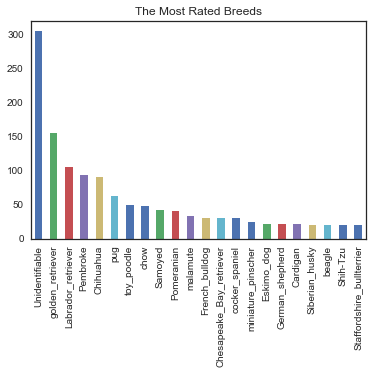

In [95]:
# Without specify the lengh we don't get good result so we will subset our data on the most owned
breed = df.groupby('breed').filter(lambda x: len(x) >= 20)
breed['breed'].value_counts().plot(kind = 'bar')
plt.title('The Most Rated Breeds');

##### Summary 
- Results of this analysis show that golden_retriever and beagle are the most and least rated breeds.

#### The most favorite dog stages

(-1.2907931902902257,
 1.2443276617071928,
 -1.2108204625455086,
 1.2097632693761426)

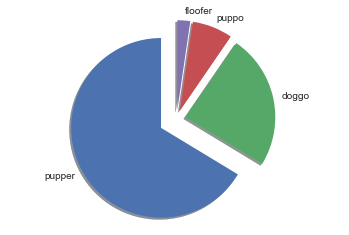

In [96]:
count = list(df[df['Stages'] != 'None']['Stages'].value_counts())[0:4]
stages = df[df['Stages'] != 'None']['Stages'].value_counts().index.tolist()[0:4]
explode = (0.2, 0.1, 0.1, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(count, explode = explode, labels = stages, shadow = True, startangle = 90)
ax1.axis('equal')

In [97]:
df[df['Stages'] != 'None'].groupby('Stages')['rating_numerator'].mean()

Stages
doggo      11.794521
floofer    12.000000
pupper     10.623234
puppo      12.000000
Name: rating_numerator, dtype: float64

##### Summary
- Figure illustrates that Puppers is the most favoritere stage of the dog. However, it obtained the lowest mean rating.